# CS4220 Project 2 - Pathogen Detection

In this notebook, we give an example to show how to read and use the DNA read data. We will train one base line model, using `sklearn.LogisticRegression`, and use it to predict the pathogens in each patient's dataset.

## Related python packages

To get started (if you are using python), you may want to create a virtual python environment and install some packages. Here are some of the commands you might need:

```bash
conda create --name cs4220 python=3.8

# Install jupyter notebook if you are using it
conda install -c anaconda ipykernel
python -m ipykernel install --user --name=cs4220
conda install -c anaconda jupyter

# Some common packages
conda install pandas                      # for reading csv
conda install scikit-learn                # for the logistic regression model
pip install pytorch                       # if you are using neural networks
conda install -c conda-forge matplotlib   # for plotting
conda install seaborn                     # also for plotting
pip install umap-learn[plot]              # plotting UMAP plots
conda install numpy                       # for many math/vectorized operations
```

In [196]:
# import packages

import numpy as np
import pandas as pd
import timeit
import time
import statistics 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from umap.umap_ import UMAP
from joblib import dump, load
from itertools import chain
from typing import Union, Any

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Non-linear classifiers
from sklearn import svm # Should do with RBF or polynomial kernel
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier 
# Note OVR -- sensitive to imbalanced dataset, OVO is less sensitive
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)

from utils.common import *
from utils.dataset import CS4220Dataset
from utils.feature_selection import *
from utils.model_evaluation import _read_model, get_all_jaccard_index, performance_evaluate, get_all_jaccard_index_with_transformation

In [279]:
from importlib import reload
import utils.common
reload(utils.common)
from utils.common import *

In [192]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import colorcet
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd

import umap.plot
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [184]:
# Check the current working directory
curr_dir=%pwd
curr_dir

'/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection'

## Testing Utils

In [185]:

def random_forest_selector(X,y):
    model = RandomForestClassifier(random_state=1, max_depth=10)
    model.fit(X,y)
    features = df.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)[-9:]  # top 10 features
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

def create_coarse_labels(df):
    df['coarse_species_name'] = np.where(df['species_name'] != "decoy", "non_decoy", "decoy")
    le = preprocessing.LabelEncoder()
    le.fit(df['coarse_species_name'].unique())
    y_index = le.transform(df['coarse_species_name'].values)
    df['labels'] = y_index
    print(f"Unique labels {len(df['coarse_species_name'].unique())}")
    return df, le

def filtered_array(array, idx_to_drop):
    return np.take(array, idx_to_drop, axis=1)
    
def jaccard_index_per_patient(patient_id:str, preds):
    # Generic filename
    df_true = pd.read_csv('test_data/patient{}_labels.csv'.format(patient_id))
    tp, fp, tp_fn = 0, 0, df_true['labels'].shape[0]
    print('my predition(s) for patient {}:'.format(patient_id))
    print(preds)
    print('true pathogen')
    print(df_true['labels'].values)
    # if don't predict any pathogen, it means there is only decoy in the test dataset (your prediction)
    if len(preds) == 0:
        preds = ['decoy']
    for item in np.unique(preds):
        if item in df_true['labels'].values:
            tp += 1
        else:
            fp += 1
    #you have to predict all labels correctly, but you are penalized for any false positive
    return tp / (tp_fn + fp) , preds, df_true['labels'].values

def get_all_jaccard_index_with_filter( model:Any, label_encoder:Any , filtered_idx:Any, num_patients:int=10, threshold:float=0.95):

    all_jaccard_index = []
    all_pred = []
    all_true = []
    for patient_id in range(num_patients):
        print('predicting for patient {}'.format(patient_id))

        with open('test_data/patient{}_6mers.npy'.format(patient_id), 'rb') as read_file:
            df_test = np.load(read_file)

        # regr.predict relies on argmax, thus predict to every single read and you will end up with many false positives
        transformed_data = filtered_array(df_test,filtered_idx)
        print(f"Shape of {transformed_data.shape}")
        y_pred = model.predict(transformed_data)

        # we can use regr.predict_proba to find a good threshold and predict only for case where the model is confident.
        # here I apply 0.95 as the cutoff for my predictions, let's see how well my model will behave...
        y_predprob = model.predict_proba(transformed_data)

        # we get only predictions larger than the threshold and if there is more than one, we take the argmax again
        final_predictions = label_encoder.inverse_transform(
                                np.unique([np.argmax(item) for item in y_predprob if len(np.where(item >= threshold)[0]) >= 1]
                            ))

        # my pathogens dectected, decoy will be ignored
        final_predictions = [item for item in final_predictions if item !='decoy']

        ji, pred_pathogen, true_pathogen = jaccard_index_per_patient(patient_id, final_predictions)
        print('Jaccard index: {}'.format(ji))
        all_jaccard_index.append(ji)    
        all_pred.append(pred_pathogen)
        all_true.append(true_pathogen)
    # print(f'all_pred: {all_pred}')
    # print(f'all_true: {all_true}')
    all_pred_flat = [item for sublist in all_pred for item in sublist]
    all_true_flat = [item for sublist in all_true for item in sublist]
    return all_jaccard_index, all_pred_flat, all_true_flat

## Parsing Input Data

First, some dataset statistics. We load our training labels (ground truth) and see how many reads a category (species) have.

In [186]:
label_df = pd.read_csv('./training_data/train_labels.csv')
get_species_count(label_df)

(461581,
 species_name
 decoy                              413476
 burkholderia_pseudomallei            3533
 pseudomonas_aeruginosa               3126
 klebsiella_michiganensis             2989
 mycobacterium_ulcerans               2910
 klebsiella_pneumoniae                2806
 serratia_liquefaciens                2629
 vibrio_parahaemolyticus              2579
 salmonella_enterica_typhimurium      2507
 yersinia_enterocolitica              2276
 stenotrophomonas_maltophilia         2217
 mycobacterium_tuberculosis           2175
 clostridioides_difficile             2007
 acinetobacter_baumannii              1964
 legionella_pneumophila               1753
 listeria_monocytogenes               1479
 staphylococcus_aureus                1384
 staphylococcus_pseudintermedius      1328
 corynebacterium_ulcerans             1266
 corynebacterium_diphtheriae          1194
 streptococcus_suis                   1092
 neisseria_gonorrhoeae                1087
 streptococcus_agalactiae      

In [187]:
coarse_label_df ,coarse_label_encoder = create_coarse_labels(label_df)

Unique labels 2


It seems that we have a lot of decoy reads (decoy means sequencing reads from human or commensal species).

In [188]:
# snippet to load the grouth truth training labels and normalize the label predictions.
# your trained model will predict in this space (26 classes - pathogens and decoy)
processed_label_df ,label_encoder = create_label_df(label_df)
#this label_df will have label index instead of the actual class value

Unique labels 26


We are not training using the full dataset to provide a quick baseline here. Thus, we subsampled so that each category has 500 reads. Up to you to come up with interesting training strategies to use your full training dataset (or even your own datasets)!

In [204]:
#800 here means that there are at most 800 per label class
# find ways to reduce the sample size as there are >10000 samples

samples_800_index = create_sampling_idx(label_df,800)
display(samples_800_index)

Index([  120,   623,  1758,  1634,  1919,  1310,   708,  1335,  1446,  1510,
       ...
       46459, 46356, 46881, 45929, 46402, 47039, 48081, 47194, 46790, 47938],
      dtype='int64', length=20800)

In [194]:
create_sampling_idx

<function utils.common.create_sampling_idx(df, sample_num: int)>

In this project, we try to use canonical $k$-mer profiles to represent each read in the input. Here, we are using $k=6$ and consequently 2081 features (including 1 feature `IGNORE` for ambiguous $k$-mer) for each read. Read [this reference](https://bioinfologics.github.io/post/2018/09/17/k-mer-counting-part-i-introduction/) for more information.

To help you save time, we implemented a utility class `CS4220Dataset` that can
- take in raw reads as input (`.fasta`, `.fa` files), and turn them into $k$-mer profiles, or
- take in $k$-mer profile as input (`.npy` files),
- allow you to sample data or create $k$-mer profile on the fly (during training) to save memory.

In [205]:
# Example usage
#input_file_path = './training_data/train_raw_reads.fasta'
input_file_path = './training_data/train_6mers.npy'

coarse_sampled_dataset = CS4220Dataset(data_file=input_file_path, label_df=coarse_label_df, samples_index=samples_800_index)
print(len(coarse_sampled_dataset.X[:, :-1]), len(coarse_sampled_dataset.X[:, :-1][0])) # each row represent the sequence and each featuere represent the unique k-mers profile and the values represent the frequencies to it; exclude the last col as that is ambiguous
print(len(coarse_sampled_dataset.Y))

20800 2080
20800


In [206]:
# Example usage
#input_file_path = './training_data/train_raw_reads.fasta'
input_file_path = './training_data/train_6mers.npy'

sampled_dataset = CS4220Dataset(data_file=input_file_path, label_df=processed_label_df, samples_index=samples_800_index)
print(len(sampled_dataset.X[:, :-1]), len(sampled_dataset.X[:, :-1][0])) # each row represent the sequence and each featuere represent the unique k-mers profile and the values represent the frequencies to it; exclude the last col as that is ambiguous
print(len(sampled_dataset.Y))

20800 2080
20800


In [207]:
# Using all data
all_dataset = CS4220Dataset(data_file=input_file_path, label_df=processed_label_df)
print(len(all_dataset.X[:, :-1]), len(all_dataset.X[:, :-1][0])) # each row represent the sequence and each featuere represent the unique k-mers profile and the values represent the frequencies to it; exclude the last col as that is ambiguous
print(len(all_dataset.Y))

461581 2080
461581


## Individual Dataset Preparation

### Features by Std

In [261]:
# Getting all the low variation of mean kmer 
STD_DEV_THRESHOLD = 0.0001
kmer_analysis = get_kmer_analysis_map(sampled_dataset)

# For entire dataset
getting_no_kmer_existence(kmer_analysis)
std_accross_labels_sorted = get_std_across_labels_by_kmer(kmer_analysis)

# Tunable parameter
sampled_dataset_features_to_keep = [key for key, elem in std_accross_labels_sorted.items() if elem >  STD_DEV_THRESHOLD]

idx_keep_by_std_filter = sampled_dataset.X_mapped.columns.get_indexer(sampled_dataset_features_to_keep)

 label 3 ::  ['CGATCG']


In [262]:
len(sampled_dataset_features_to_keep)

1940

In [263]:
array_by_std_filter = np.take(sampled_dataset.X, idx_keep_by_std_filter, axis=1)
# array_by_std_filter = np.take(all_dataset.X, idx_keep_by_std_filter, axis=1)

In [264]:
array_by_std_filter.shape

(20800, 1940)

In [265]:
std_accross_labels_sorted.keys()

dict_keys(['CCTAGG', 'CCCCTA', 'GCCCTA', 'CCCTAC', 'TACGTA', 'AGGTTC', 'CACTAC', 'GTATAC', 'GAATTC', 'AGGTAC', 'CTACAC', 'ACCCTA', 'CGTCTA', 'ATGGAC', 'GCTAGC', 'CCCCCC', 'AGATCT', 'AGTACT', 'GAGTAC', 'ACCCCT', 'GGACTA', 'TGTACA', 'ACTAGT', 'ACTACC', 'GTACAC', 'ATAGGG', 'CCCTAG', 'GACCTA', 'CTTAAG', 'GTAGAC', 'AGATGC', 'AGGGAC', 'AGTACC', 'ACCTAC', 'AAGGGT', 'AGAACC', 'AGGGGG', 'ACATGT', 'CGTACG', 'GGGCTA', 'TTCGAA', 'GGGACA', 'GGTAGA', 'GGATAC', 'GGGGTA', 'AGTCCC', 'CGACTA', 'AAGGGG', 'CGTGTA', 'TCTAGA', 'GGTCTA', 'GGTTCA', 'CCTACA', 'GTCCTA', 'ATGTCC', 'CTATGC', 'CCTAAC', 'GGTACC', 'GATCTA', 'CGAGTA', 'GCTACA', 'ACACTC', 'GATGGA', 'AGTGTC', 'TAGGGA', 'GCATAC', 'CTATCC', 'GGTACA', 'AGAGCC', 'CCACTC', 'CACGTG', 'CGAGAG', 'CTACCC', 'CTCGTA', 'AGGGTA', 'CTAACC', 'ACGGAG', 'GGCCTA', 'CAGAAC', 'ACATCC', 'GCACTA', 'ATAGGC', 'CCTTAC', 'AACCCT', 'CTAGGC', 'GTACGA', 'AGAGGC', 'CCACTA', 'ACGTCT', 'GGGTAC', 'ACTCCC', 'CTGTAC', 'GAGGTA', 'ACCCTC', 'CCCGTA', 'ACCCAT', 'CCTAAG', 'GACTAC', 'ACTGTC',

In [250]:
# Getting all the low variation of mean kmer 
STD_DEV_THRESHOLD = 0.0001
kmer_analysis = get_kmer_analysis_map(all_dataset)

# For entire dataset
getting_no_kmer_existence(kmer_analysis)
std_accross_labels_sorted = get_std_across_labels_by_kmer(kmer_analysis)

# Tunable parameter
all_dataset_features_to_keep = [key for key, elem in std_accross_labels_sorted.items() if elem >  STD_DEV_THRESHOLD]

idx_keep_by_std_filter = all_dataset.X_mapped.columns.get_indexer(all_dataset_features_to_keep)

 label 3 ::  ['CGATCG']


### Features by Feature Importance

In [271]:
# NUMBER
NUMBER_TO_DROP = 1081
feature_impt = pd.read_csv("assets/feature_impt.csv")
idx_keep_by_feature_impt = feature_impt.sort_values(by="importances").iloc[NUMBER_TO_DROP:].index


In [272]:
array_by_feature_impt = np.take(sampled_dataset.X, idx_keep_by_feature_impt, axis=1)

In [273]:
array_by_feature_impt.shape

(20800, 1000)

## Modelling

In [266]:
# feature impt set 
starting_time = timeit.default_timer()

model = RandomForestClassifier(random_state=1, n_estimators=300, max_depth=16,verbose=1)
%timeit
# Train the model using the training sets
model.fit(array_by_std_filter, sampled_dataset.Y)
dump(model, 'models/rf_std_filter.joblib')
print("Time taken :", timeit.default_timer() - starting_time)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   26.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.8min


Time taken : 159.02667733401177


In [267]:
array_by_std_filter.shape

(20800, 1940)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s


 Macro Precision :  1.00, Recall :  1.00, F1 :  1.00
 Micro Precision :  1.00, Recall :  1.00, F1 :  1.00


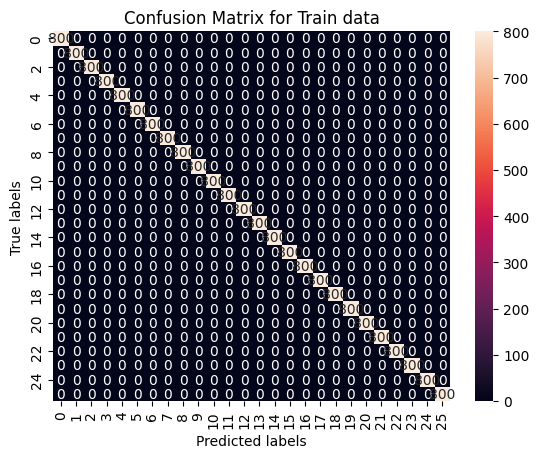

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s


 Macro Precision :  1.00, Recall :  1.00, F1 :  1.00
 Micro Precision :  1.00, Recall :  1.00, F1 :  1.00


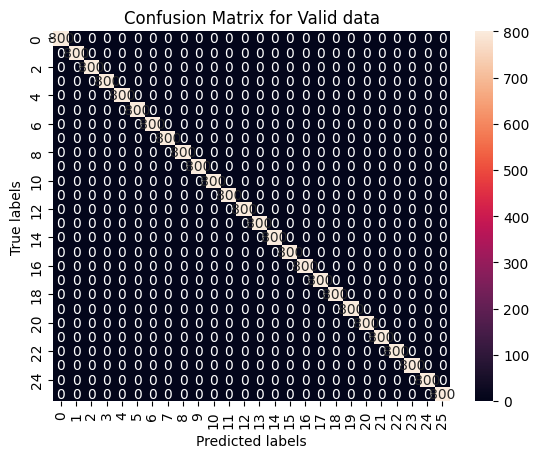

predicting for patient 0
Shape of (10054, 1940)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


my predition(s) for patient 0:
['staphylococcus_aureus']
true pathogen
['staphylococcus_aureus']
Jaccard index: 1.0
predicting for patient 1
Shape of (10132, 1940)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


my predition(s) for patient 1:
['neisseria_gonorrhoeae']
true pathogen
['staphylococcus_pyogenes']
Jaccard index: 0.0
predicting for patient 2
Shape of (10022, 1940)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


my predition(s) for patient 2:
['burkholderia_pseudomallei']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
Jaccard index: 0.5
predicting for patient 3
Shape of (9984, 1940)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


my predition(s) for patient 3:
['pseudomonas_aeruginosa']
true pathogen
['pseudomonas_aeruginosa']
Jaccard index: 1.0
predicting for patient 4
Shape of (10086, 1940)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


my predition(s) for patient 4:
['corynebacterium_diphtheriae']
true pathogen
['corynebacterium_diphtheriae']
Jaccard index: 1.0
predicting for patient 5
Shape of (10046, 1940)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


my predition(s) for patient 5:
[]
true pathogen
['streptococcus_pneumoniae']
Jaccard index: 0.0
predicting for patient 6
Shape of (9974, 1940)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


my predition(s) for patient 6:
[]
true pathogen
['mycobacterium_ulcerans']
Jaccard index: 0.0
predicting for patient 7
Shape of (10046, 1940)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


my predition(s) for patient 7:
['neisseria_gonorrhoeae']
true pathogen
['mycobacterium_tuberculosis' 'streptococcus_pneumoniae']
Jaccard index: 0.0
predicting for patient 8
Shape of (10009, 1940)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


my predition(s) for patient 8:
[]
true pathogen
['streptococcus_pneumoniae']
Jaccard index: 0.0
predicting for patient 9
Shape of (10074, 1940)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


my predition(s) for patient 9:
['burkholderia_pseudomallei', 'neisseria_gonorrhoeae']
true pathogen
['burkholderia_pseudomallei']
Jaccard index: 0.5
['patient 0: 1.0', 'patient 1: 0.0', 'patient 2: 0.5', 'patient 3: 1.0', 'patient 4: 1.0', 'patient 5: 0.0', 'patient 6: 0.0', 'patient 7: 0.0', 'patient 8: 0.0', 'patient 9: 0.5'] avg: 0.4


In [270]:
performance_evaluate(
    train_dataset=(array_by_std_filter, sampled_dataset.Y),
    valid_dataset=(array_by_std_filter, sampled_dataset.Y),
    model_name="rf_std_filter",
    filepath="models"
)

sampled_jaccard_index, sampled_pred, sampled_true = get_all_jaccard_index_with_filter(model=model, label_encoder=label_encoder,filtered_idx=idx_keep_by_std_filter, threshold=0.7 )

print(['patient {}: {}'.format(c,item) for c, item in enumerate(sampled_jaccard_index)], 'avg: {}'.format(np.mean(sampled_jaccard_index)))

In [274]:
array_by_feature_impt.shape

(20800, 1000)

In [276]:
# feature impt set 
starting_time = timeit.default_timer()

model = RandomForestClassifier(random_state=1, n_estimators=300, max_depth=16,verbose=1)
%timeit
# Train the model using the training sets
model.fit(array_by_feature_impt, sampled_dataset.Y)
dump(model, 'models/rf_feature_impt_filtered_1000.joblib')
print("Time taken :", timeit.default_timer() - starting_time)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   18.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.2min


Time taken : 113.02029766698251


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


 Macro Precision :  1.00, Recall :  1.00, F1 :  1.00
 Micro Precision :  1.00, Recall :  1.00, F1 :  1.00


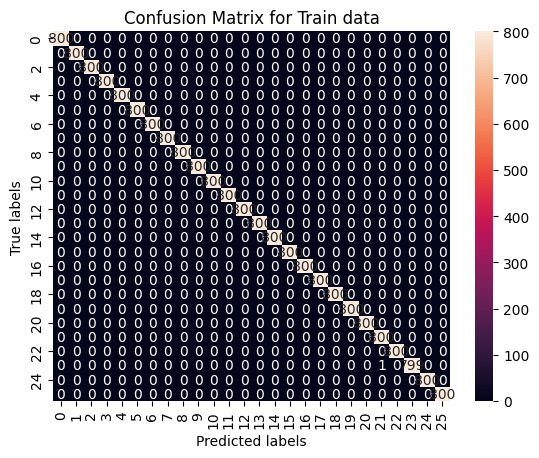

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


 Macro Precision :  1.00, Recall :  1.00, F1 :  1.00
 Micro Precision :  1.00, Recall :  1.00, F1 :  1.00


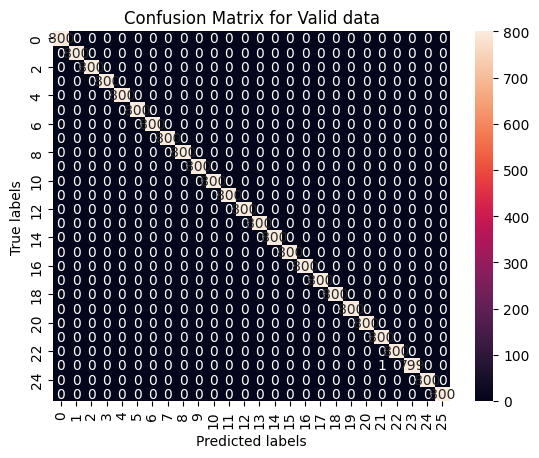

predicting for patient 0
Shape of (10054, 1000)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


my predition(s) for patient 0:
['staphylococcus_aureus']
true pathogen
['staphylococcus_aureus']
Jaccard index: 1.0
predicting for patient 1
Shape of (10132, 1000)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


my predition(s) for patient 1:
['neisseria_gonorrhoeae']
true pathogen
['staphylococcus_pyogenes']
Jaccard index: 0.0
predicting for patient 2
Shape of (10022, 1000)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


my predition(s) for patient 2:
['burkholderia_pseudomallei', 'clostridioides_difficile', 'corynebacterium_ulcerans']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
Jaccard index: 0.6666666666666666
predicting for patient 3
Shape of (9984, 1000)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


my predition(s) for patient 3:
['pseudomonas_aeruginosa']
true pathogen
['pseudomonas_aeruginosa']
Jaccard index: 1.0
predicting for patient 4
Shape of (10086, 1000)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


my predition(s) for patient 4:
['corynebacterium_diphtheriae']
true pathogen
['corynebacterium_diphtheriae']
Jaccard index: 1.0
predicting for patient 5
Shape of (10046, 1000)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


my predition(s) for patient 5:
['streptococcus_pneumoniae']
true pathogen
['streptococcus_pneumoniae']
Jaccard index: 1.0
predicting for patient 6
Shape of (9974, 1000)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


my predition(s) for patient 6:
['mycobacterium_ulcerans']
true pathogen
['mycobacterium_ulcerans']
Jaccard index: 1.0
predicting for patient 7
Shape of (10046, 1000)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


my predition(s) for patient 7:
['neisseria_gonorrhoeae']
true pathogen
['mycobacterium_tuberculosis' 'streptococcus_pneumoniae']
Jaccard index: 0.0
predicting for patient 8
Shape of (10009, 1000)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


my predition(s) for patient 8:
['streptococcus_pneumoniae']
true pathogen
['streptococcus_pneumoniae']
Jaccard index: 1.0
predicting for patient 9
Shape of (10074, 1000)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


my predition(s) for patient 9:
['burkholderia_pseudomallei', 'neisseria_gonorrhoeae', 'salmonella_enterica_typhimurium']
true pathogen
['burkholderia_pseudomallei']
Jaccard index: 0.3333333333333333
['patient 0: 1.0', 'patient 1: 0.0', 'patient 2: 0.6666666666666666', 'patient 3: 1.0', 'patient 4: 1.0', 'patient 5: 1.0', 'patient 6: 1.0', 'patient 7: 0.0', 'patient 8: 1.0', 'patient 9: 0.3333333333333333'] avg: 0.7


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


In [278]:
performance_evaluate(
    train_dataset=(array_by_feature_impt, sampled_dataset.Y),
    valid_dataset=(array_by_feature_impt, sampled_dataset.Y),
    model_name="rf_feature_impt_filtered_1000",
    filepath="models"
)

sampled_jaccard_index, sampled_pred, sampled_true = get_all_jaccard_index_with_filter(model=model, label_encoder=label_encoder,filtered_idx=idx_keep_by_feature_impt, threshold=0.6)

print(['patient {}: {}'.format(c,item) for c, item in enumerate(sampled_jaccard_index)], 'avg: {}'.format(np.mean(sampled_jaccard_index)))

The data and labels are then accessible via `sampled_dataset.X` and `sampled_dataset.Y`.

## Quick Exploratory Data Analysis

We can use a [UMAP plot](https://www.scdiscoveries.com/blog/knowledge/what-is-a-umap-plot/) to try to group reads in the same species together, according to their $k$-mer profiles.

In [ ]:
# the last column of our 6mer training dataset can be ignored
# UMAP aims to find a low dimensional representation of the data [https://umap-learn.readthedocs.io/en/latest/parameters.html]
# UMAP hyperparameters that impact the data -- n_neighbours, min_dist, n_components, metric
# n_neighbors: controls how UMAP balances local versus global structure -- low neighbors will cause UMAP to 
# focus on very local structures -- (Default values : 15)

# min_dist: (Default values: 0.1) -- controls how tightly UMAP is allowed to pack points together , lower value of min_dist will 
# result in clumpier embeddings. This will be 

# n_component: (Default = 2) Number of dimensions, n=1 UMAP data will fall into a line
# metric: (Default)
mapper = UMAP(metric="euclidean").fit(sampled_dataset.X[:, :-1])

labels_tc = label_encoder.inverse_transform(sampled_dataset.Y)
ax = umap.plot.points(mapper, labels=labels_tc,  width=1500, height=1500)

In [ ]:
# Doing a UMAP for 2 coarse grained model

mapper = UMAP(metric="euclidean").fit(coarse_sampled_dataset.X[:, :-1])

coarse_labels_tc = coarse_label_encoder.inverse_transform(coarse_sampled_dataset.Y)
ax = umap.plot.points(mapper, labels=coarse_labels_tc,  width=1500, height=1500)

In [ ]:
# UMAP for the whole dataset
mapper = UMAP(metric="euclidean").fit(all_dataset.X[:, :-1])

labels_tc = le.inverse_transform(all_dataset.Y)
ax = umap.plot.points(mapper, labels=labels_tc,  width=1500, height=1500)

#### Just trying to integrate PCA into the UMAP to reduce the number of features and see if it cluster better but that doesn't seem to be the case 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2080)  # Use the maximum number of components
pca.fit(sampled_dataset.X[:, :-1])
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.grid(True)
plt.show()


In [ ]:
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_95

In [ ]:
sampled_X=sampled_dataset.X[:, :-1]
pca = PCA(n_components=1060)  # Specify the number of components to keep
sampled_X_pca = pca.fit_transform(sampled_X)
mapper_pca = UMAP().fit(sampled_X_pca)
labels_tc_pca = le.inverse_transform(sampled_dataset.Y)
ax = umap.plot.points(mapper_pca, labels=labels_tc_pca,  width=1500, height=1500)

What interesting patterns can you notice? Some observations might be:
- Some species are pretty separated in clusters.
- Even though most species lie in separate groups, we can see some regions where points from different species are overlapping.
- There are some "lost points" for pretty much every species.

Do you think these pieces of information can help you in something? Think about it.

Eugene's take on it:
- certain species have distinct genomic or sequence profiles that differentiate them from other species in the dataset
- the overlapping regions suggest shared genomic sequence between closely related species
- The "lost points" refer to data points that do not clearly belong to any specific cluster or group in the UMAP plot.


## Training

OK, time for training. As baseline we will choose the simplest [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) model.

You can fine-tune the logistic regression hyperparameters such as the penalty and regularization term.

```python
from sklearn.model_selection import GridSearchCV

#list of items to tune
parameters_lr = [{'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

starting_time = timeit.default_timer()

regr = LogisticRegression(random_state=2023, solver='saga', n_jobs=-1, class_weight='balanced', max_iter=50, verbose=1)

grid_search_lr = GridSearchCV(estimator = regr,
                              param_grid = parameters_lr,
                              scoring = 'accuracy',
                              cv = 3,
                              n_jobs = -1)

# the last column of our 6mer training dataset can be ignored (training labels)
grid_search_lr.fit(sampled_dataset.X, sampled_dataset.Y)
best_accuracy_lr = grid_search_lr.best_score_
best_parameter_lr = grid_search_lr.best_params_

```

This might take a long time. Here, we skip this step and jump straight to training.

In [ ]:
from sklearn.model_selection import train_test_split
# Having a training/validation set
X_train, X_test, y_train, y_test = train_test_split(sampled_dataset.X, sampled_dataset.Y,
                                                    stratify=sampled_dataset.Y, 
                                                    test_size=0.1)

In [ ]:
# Using a smaller lightweight model
from sklearn.naive_bayes import ComplementNB

clf = ComplementNB()
clf.fit(X_train, y_train)

dump(clf, 'models/nb_model.joblib')

In [ ]:
# linear classifier using scikit-learn
# Best Parameter of LR: {'C': 100, 'penalty': 'l1'}

starting_time = timeit.default_timer()

regr = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=100, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(X_train, y_train)
dump(regr, 'models/log_reg.joblib')
print("Time taken :", timeit.default_timer() - starting_time)

In [ ]:
performance_evaluate(
    train_dataset=(X_train, y_train),
    valid_dataset=(X_test,y_test),
    model_name="log_reg",
    filepath="models"
)

all_jaccard_index, all_pred, all_true = get_all_jaccard_index(model=regr, label_encoder=label_encoder)

In [ ]:
np.mean(all_jaccard_index)

In [ ]:
# linear classifier using scikit-learn
# Best Parameter of LR: {'C': 100, 'penalty': 'l1'}

starting_time = timeit.default_timer()

regr = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=50, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(sampled_dataset.X, sampled_dataset.Y)
print("Time taken :", timeit.default_timer() - starting_time)
dump(regr, 'models/log_reg_orig.joblib')

In [ ]:
performance_evaluate(
    train_dataset=(sampled_dataset.X, sampled_dataset.Y),
    valid_dataset=(sampled_dataset.X, sampled_dataset.Y),
    model_name="baseline",
    filepath="models"
)

baseline_model =_read_model(filepath="models", model_name="baseline")
all_jaccard_index, all_pred, all_true = get_all_jaccard_index(model=baseline_model, label_encoder=label_encoder)

In [ ]:
all_jaccard_index

We can now save our trained model for later usage. This is an example of how you can send your model to our final evaluation.

In [ ]:
from joblib import dump, load
dump(regr, 'models/baseline.joblib')

### Trying out the GridSearchCV method he suggested but takes even longer and coef_ did not coverge as max_iter of 500 is reached

In [ ]:
from sklearn.model_selection import GridSearchCV

#list of items to tune
parameters_lr = [{'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

starting_time = timeit.default_timer()

regr = LogisticRegression(random_state=2023, solver='saga', n_jobs=-1, class_weight='balanced', max_iter=500, verbose=1)

grid_search_lr = GridSearchCV(estimator = regr,
                              param_grid = parameters_lr,
                              scoring = 'accuracy',
                              cv = 3,
                              n_jobs = -1)

# the last column of our 6mer training dataset can be ignored (training labels)
grid_search_lr.fit(sampled_dataset.X, sampled_dataset.Y)
best_accuracy_lr = grid_search_lr.best_score_
best_parameter_lr = grid_search_lr.best_params_

In [ ]:
np.random.random()

Then the model can be loaded using

```python
# load trained model
regr = load('models/baseline.joblib')
```

## Evaluation of Model

Now that you have your trained model, you can use it on each of the patient's read dataset and try to find the pathogens that appear in each patient.

Your model is evaluated based on [**Jaccard index**](https://en.wikipedia.org/wiki/Jaccard_index#Jaccard_index_in_binary_classification_confusion_matrices). For patient $i$, let $P$ be the set of pathogen species your model predicted (or $\{\text{decoy}\}$ if there is no pathogens predicted), and $T$ the set of pathogen species the patient actually have (or $\{\text{decoy}\}$ if there is no pathogens in the reads), the score for your model is

$$\text{Jaccard index}=\frac{|P\cap T|}{|P \cup T|}$$

Going back to our model: since we are using logistic regression, our model will classify each read to the class that has the highest probability of having the read. If we report all the species that a read has been classified to, then we may end up with a lot of false positives (why?).

One potential way to counter this is to define a threshold. Here I used 0.95: I only report a species if I am 95% confident that one read comes from that species. Let's see how well my model will behave...

In [ ]:
baseline_model =_read_model(filepath="models", model_name="baseline")
all_jaccard_index, all_pred, all_true = get_all_jaccard_index(model=baseline_model, label_encoder=label_encoder)

In [ ]:
print(['patient {}: {}'.format(c,item) for c, item in enumerate(all_jaccard_index)], 'avg: {}'.format(np.mean(all_jaccard_index)))

In [ ]:
set(all_true)

In [ ]:
set(all_pred)

So the overall score for my model is 0.45. Not a bad start, but still much room for improvement. You don't necessarily need to work on this baseline; this was just released as an example. Have fun!!!